In [1]:
import chess
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from icecream import ic

import time

import random

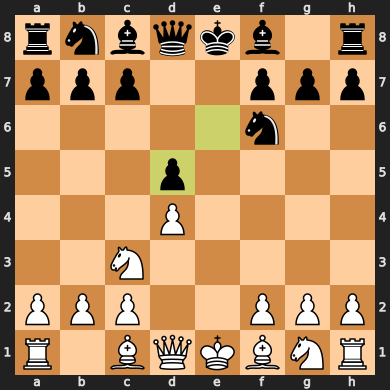

In [4]:
board

In [13]:
SYMBOL_TO_INDEX = {
    'P': 0,
    'N': 1,
    'B': 2,
    'R': 3,
    'Q': 4,
    'K': 5,
    'p': 6,
    'n': 7,
    'b': 8,
    'r': 9,
    'q': 10,
    'k': 11,
    '.': 12
}

SCORE_TENSOR = torch.tensor([1, -1]).type(torch.float32).to("cuda")

WHITE_VICOTORY = torch.tensor([100, 0]).type(torch.float32).to("cuda")
BLACK_VICTORY = torch.tensor([0, 100]).type(torch.float32).to("cuda")
DRAW = torch.tensor([0.5, 0.5]).type(torch.float32).to("cuda")

TIME_IT = False

board = chess.Board()

class FFN(nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(64*13, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, 64*13)  # Reshape the input to match the first layer's expected input size
        x = self.fc_layers(x)
        return x

# Create an instance of the FFN model
model = FFN()
model = model.to('cuda')


In [3]:
torch.randn(1, 13, 8, 8).shape

torch.Size([1, 13, 8, 8])

In [4]:
model(torch.randn(500, 64*13).to('cuda'))

tensor([[0.4811, 0.5189],
        [0.4616, 0.5384],
        [0.4651, 0.5349],
        [0.4513, 0.5487],
        [0.4824, 0.5176],
        [0.4698, 0.5302],
        [0.4597, 0.5403],
        [0.5116, 0.4884],
        [0.4714, 0.5286],
        [0.4885, 0.5115],
        [0.4859, 0.5141],
        [0.4889, 0.5111],
        [0.4801, 0.5199],
        [0.4769, 0.5231],
        [0.4389, 0.5611],
        [0.5191, 0.4809],
        [0.4852, 0.5148],
        [0.5140, 0.4860],
        [0.4757, 0.5243],
        [0.5106, 0.4894],
        [0.4788, 0.5212],
        [0.4944, 0.5056],
        [0.5081, 0.4919],
        [0.5052, 0.4948],
        [0.4994, 0.5006],
        [0.4856, 0.5144],
        [0.4451, 0.5549],
        [0.4689, 0.5311],
        [0.4819, 0.5181],
        [0.5070, 0.4930],
        [0.5041, 0.4959],
        [0.4628, 0.5372],
        [0.4939, 0.5061],
        [0.4939, 0.5061],
        [0.5155, 0.4845],
        [0.4649, 0.5351],
        [0.4666, 0.5334],
        [0.4914, 0.5086],
        [0.4

In [5]:
def time_it(func, name, *args, **kwargs):
    if not TIME_IT:
        return func(*args, **kwargs)
    start = time.time()
    result = func(*args, **kwargs)
    print(f"Time taken by {name}: {time.time() - start} seconds")
    return result

In [6]:
def time_it(func, name, *args, **kwargs):
    if not TIME_IT:
        return func(*args, **kwargs)
    start = time.time()
    result = func(*args, **kwargs)
    print(f"Time taken by {name}: {time.time() - start} seconds")
    return result

def boards2tensor(boards):
    # Pre-allocate the tensor for all boards
    all_boards = []

    for board in boards:
        # Convert the board to index values using the SYMBOL_TO_INDEX mapping
        board_indexes = [SYMBOL_TO_INDEX[symbol] for symbol in str(board).replace('\n', ' ').split(' ')]
        
        # One-hot encode the board
        one_hot_board = F.one_hot(torch.tensor(board_indexes), num_classes=len(SYMBOL_TO_INDEX)).view(-1)
        
        # Add to the list
        all_boards.append(one_hot_board)

    # Stack all boards into a batch tensor and move to GPU
    batched_tensor = torch.stack(all_boards).type(torch.float32).cuda()

    return batched_tensor

def calculate_scores(model, batched_boards):
    return (model(batched_boards) * SCORE_TENSOR).sum(dim=1)

def board_score(model, boards, white_to_move):
    with torch.no_grad():
        batched_boards = time_it(boards2tensor, " boards2tensor", boards) 
        scores = time_it(calculate_scores, "calculate_scores", model, batched_boards)
        return scores if white_to_move else scores * -1 
    
def find_best_moves(model, boards, epsilon=0.3):
    
    all_legal_moves = []
    all_boards_after_move = []
    for board in boards:
        legal_moves = list(board.legal_moves)
        all_legal_moves.append(legal_moves)
        boards_after_move = []
        for move in legal_moves:
            board.push(move)
            boards_after_move.append(board.copy())
            board.pop()
        all_boards_after_move.extend(boards_after_move)
    # Get scores for all boards in one batch
    
    move_scores = board_score(model, all_boards_after_move, [board.turn for board in boards])
    
    best_moves = []
    start_idx = 0
    
    for legal_moves in all_legal_moves:
        if len(legal_moves) == 0:
            best_moves.append(None)  # Or handle appropriately
            continue

        end_idx = start_idx + len(legal_moves)

        # Epsilon-greedy strategy
        if random.random() < epsilon:
            # Choose a random move
            best_move = random.choice(legal_moves).uci()
        else:
            # Choose the best move
            best_move = legal_moves[move_scores[start_idx:end_idx].argmax()].uci()

        best_moves.append(best_move)
        start_idx = end_idx

    return best_moves

In [8]:
boards = [board.copy() for _ in range(1)]

In [9]:
time_start = time.time()
find_best_moves(model, boards)

time_end = time.time()
print(f"Time taken: {time_end - time_start}")

Time taken: 0.0069997310638427734


In [29]:
board.reset()

In [11]:
board.push_san("Nf3")

Move.from_uci('g1f3')

In [11]:
def play_a_game(time_it=False):
    counter = 0
    while not board.is_game_over():
        if time_it:
            start_time = time.time()
        counter += 1
        print(counter, end='\r')
        move = find_best_move(model, board)
        if move is None or counter > 1000:
            break
        board.push_uci(move)
        if time_it:
            end_time = time.time()
            execution_time = end_time - start_time
            print(f"Execution time: {execution_time} seconds")
    return board.result(), counter

In [10]:
ic.disable()

In [17]:
def get_reward(board):
    result = board.result()
    if result == '1-0':
        return WHITE_VICOTORY
    elif result == '0-1':
        return BLACK_VICTORY   
    else:
        return DRAW 

def train_model(model, num_games, learning_rate, num_parallel_games):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    boards = [chess.Board() for _ in range(num_parallel_games)]
    game_memories = [[] for _ in range(num_parallel_games)]
    losses = []

    for _ in tqdm(range(num_games)):
        while not all(board.is_game_over() for board in boards):
            best_moves = find_best_moves(model, boards)
            for i, move in enumerate(best_moves):
                if not boards[i].is_game_over():
                    boards[i].push_uci(move)
                    game_memories[i].append(boards2tensor([boards[i]]))

        loss = 0
        game_lengths = [len(game_memory) for game_memory in game_memories]
        for i, board in enumerate(boards):
            target_tensor = get_reward(board)
            board.reset()
            for board_state in game_memories[i]:
                model_output = model(board_state)
                loss += F.binary_cross_entropy(model_output, target_tensor.unsqueeze(0))
            loss /= len(game_memories[i])
            game_memories[i].clear()

        losses.append(loss.item())
        print(f"Loss: {loss.item()}, game lengths: {game_lengths}, outcome: {target_tensor}, predicted: {model_output}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Average loss: {sum(losses)/len(losses)}")

# Example usage
train_model(model, num_games=100, learning_rate=0.0001, num_parallel_games=1)


  1%|          | 1/100 [00:08<14:22,  8.71s/it]

Loss: 0.6932458281517029, game lengths: [390], outcome: tensor([0.5000, 0.5000], device='cuda:0'), predicted: tensor([[0.4988, 0.5012]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  2%|▏         | 2/100 [00:12<09:32,  5.84s/it]

Loss: 0.693274974822998, game lengths: [234], outcome: tensor([0.5000, 0.5000], device='cuda:0'), predicted: tensor([[0.5038, 0.4962]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  3%|▎         | 3/100 [00:18<09:45,  6.04s/it]

Loss: 0.6931755542755127, game lengths: [308], outcome: tensor([0.5000, 0.5000], device='cuda:0'), predicted: tensor([[0.5026, 0.4974]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  4%|▍         | 4/100 [00:28<11:39,  7.29s/it]

Loss: 0.6932999491691589, game lengths: [356], outcome: tensor([0.5000, 0.5000], device='cuda:0'), predicted: tensor([[0.5037, 0.4963]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  4%|▍         | 4/100 [00:32<12:51,  8.04s/it]


KeyboardInterrupt: 

In [60]:
if True:
    board.reset()
    
    board.push_san("e4")

    board.push_san("e5")

    board.push_san("Qh5")

    board.push_san("Nc6")

    board.push_san("Bc4")

    board.push_san("Nf6")
    

In [63]:
print(board)

r . b q k b . r
p p p p . p p p
. . n . . n . .
. . . . p . . Q
. . B . P . . .
. . . . . . . .
P P P P . P P P
R N B . K . N R


In [78]:
example = """. . . . k . . .
. . . . . . . .
. . . . . . . .
. . . . . . . Q
. . B . P . . .
. . . . . . . .
P P P P . P P P
R N B . K . N R"""

In [79]:
example2 = """. . . . k . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . K . . ."""

In [80]:
model(boards2tensor([example])), model(boards2tensor([example2]))

(tensor([[0.0010, 0.9973, 0.0017]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor([[4.0275e-04, 9.9891e-01, 6.8483e-04]], device='cuda:0',
        grad_fn=<SoftmaxBackward0>))

In [88]:
model(torch.rand(1, 64*13).cuda())

tensor([[1.5532e-09, 1.0000e+00, 7.0065e-09]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:

def material_balance(board):
    white = board.occupied_co[chess.WHITE]
    black = board.occupied_co[chess.BLACK]
    return (
        chess.popcount(white & board.pawns) - chess.popcount(black & board.pawns) +
        3 * (chess.popcount(white & board.knights) - chess.popcount(black & board.knights)) +
        3 * (chess.popcount(white & board.bishops) - chess.popcount(black & board.bishops)) +
        5 * (chess.popcount(white & board.rooks) - chess.popcount(black & board.rooks)) +
        9 * (chess.popcount(white & board.queens) - chess.popcount(black & board.queens))
    )
    
material_balance(board)

0

In [ ]:
model_output = model(boards2tensor([board]))
print(model_output.shape)
loss = F.cross_entropy(model_output, WHITE_VICOTORY.unsqueeze(0))
loss

torch.Size([1, 3])


tensor(1.1021, device='cuda:0', grad_fn=<DivBackward1>)

In [ ]:
white_wins = 0
black_wins = 0
draws = 0
ic.disable()
for i in range(1):
    board.reset()
    result, counter = play_a_game(time_it=True)
    print(counter)
    if result == '1-0':
        white_wins += 1
    elif result == '0-1':
        black_wins += 1
    else:
        draws += 1
        
print(f"White wins: {white_wins}")
print(f"Black wins: {black_wins}")
print(f"Draws: {draws}")

Execution time: 0.04900074005126953 seconds
Execution time: 0.037999629974365234 seconds
Execution time: 0.05402874946594238 seconds
Execution time: 0.042005300521850586 seconds
Execution time: 0.045995473861694336 seconds
Execution time: 0.05000019073486328 seconds
Execution time: 0.057004451751708984 seconds
Execution time: 0.04696512222290039 seconds
Execution time: 0.0690300464630127 seconds
Execution time: 0.0610048770904541 seconds
Execution time: 0.057997703552246094 seconds
Execution time: 0.10396766662597656 seconds
Execution time: 0.10499835014343262 seconds
Execution time: 0.04903602600097656 seconds
Execution time: 0.0630025863647461 seconds
Execution time: 0.05396246910095215 seconds
Execution time: 0.06296563148498535 seconds
Execution time: 0.05503654479980469 seconds
Execution time: 0.06200075149536133 seconds
Execution time: 0.06297063827514648 seconds
Execution time: 0.06203651428222656 seconds
Execution time: 0.061995506286621094 seconds
Execution time: 0.06899166107

KeyboardInterrupt: 

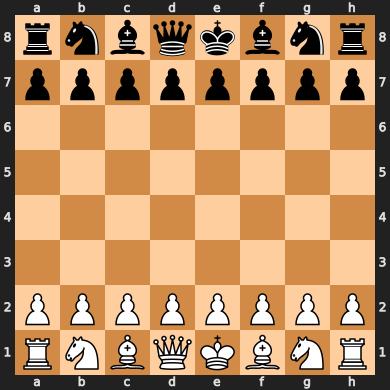

In [ ]:
board

In [ ]:
# Generate a list of all legal moves
legal_moves_list = list(board.legal_moves)

# Optionally, you can convert these moves to their string notation
legal_moves_str_list = [move.uci() for move in legal_moves_list]

# Print the list of legal moves
print(legal_moves_str_list)
print(len(legal_moves_str_list))

In [ ]:
import random

def random_legal_move(board):
    """
    Returns a random legal move for the given board.

    Args:
    board (chess.Board): The current state of the chess board.

    Returns:
    chess.Move: A random legal move.
    """
    legal_moves = list(board.legal_moves)
    legal_moves_str_list = [move.uci() for move in legal_moves]
    if legal_moves_str_list:
        return random.choice(legal_moves_str_list)
    else:
        return None  # No legal moves available

# Example usage:
# board = chess.Board()
# move = random_legal_move(board)
# print(move)


In [ ]:
counter = 0
while True:
    m = random_legal_move(board)
    counter += 1
    if m is None or board.is_game_over():
        print("game has ended", counter)
        print(board.result())
        break
    board.push_san(m)


game has ended 20
1-0


In [ ]:
board.result()

'1-0'

In [ ]:
check_game_over(board)

(True, 'Draw')

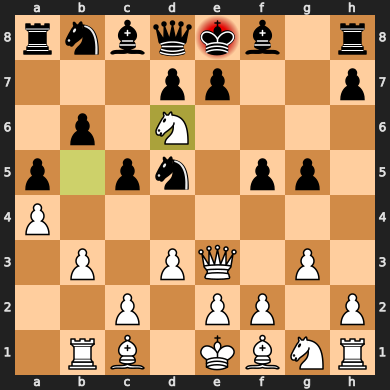

In [ ]:
board